In [1]:
cd(@__DIR__)
include(raw"utils\utils.jl")

MAPE (generic function with 2 methods)

Making a calendar of 100 years

In [2]:
try 
    using Dates
catch ; 
    import Pkg
    Pkg.add("Dates")
    using Dates
end
k=100
DatesRange=collect(Date(1900):Day(1):Date(1900+k))
N=length(DatesRange)

36525

# AR model on the whole series

## AR(2)

In [3]:
condition(r) = (imag(r) == 0) && (abs(r) > 1)
isstationnary(R::Vector)=all(condition.(RootAR(R)))

isstationnary (generic function with 1 method)

In [4]:
x0=[7.,-3]
Φ,σ=[0.1,0.5],6
isstationnary([0.1,0.5])

true

In [5]:
include("utils/Simulation.jl")
x=[x0 ; simulation(x0,Φ,σ,N-length(x0))]

36525-element Vector{Float64}:
  7.0
 -3.0
  1.5706644623358308
 -7.856685024421577
 -0.6328003472659509
  1.5331757654394895
  0.8653502339221196
 -1.9537196616302437
 -4.225776408864583
 -1.8604432867085188
  ⋮
  1.7750022980445817
  7.011773173169859
  2.4045368389780926
  5.70937821111996
  9.114145250973973
 -5.421934000715807
  0.9723206067734549
  0.16553154729635988
 -3.6976433356555205

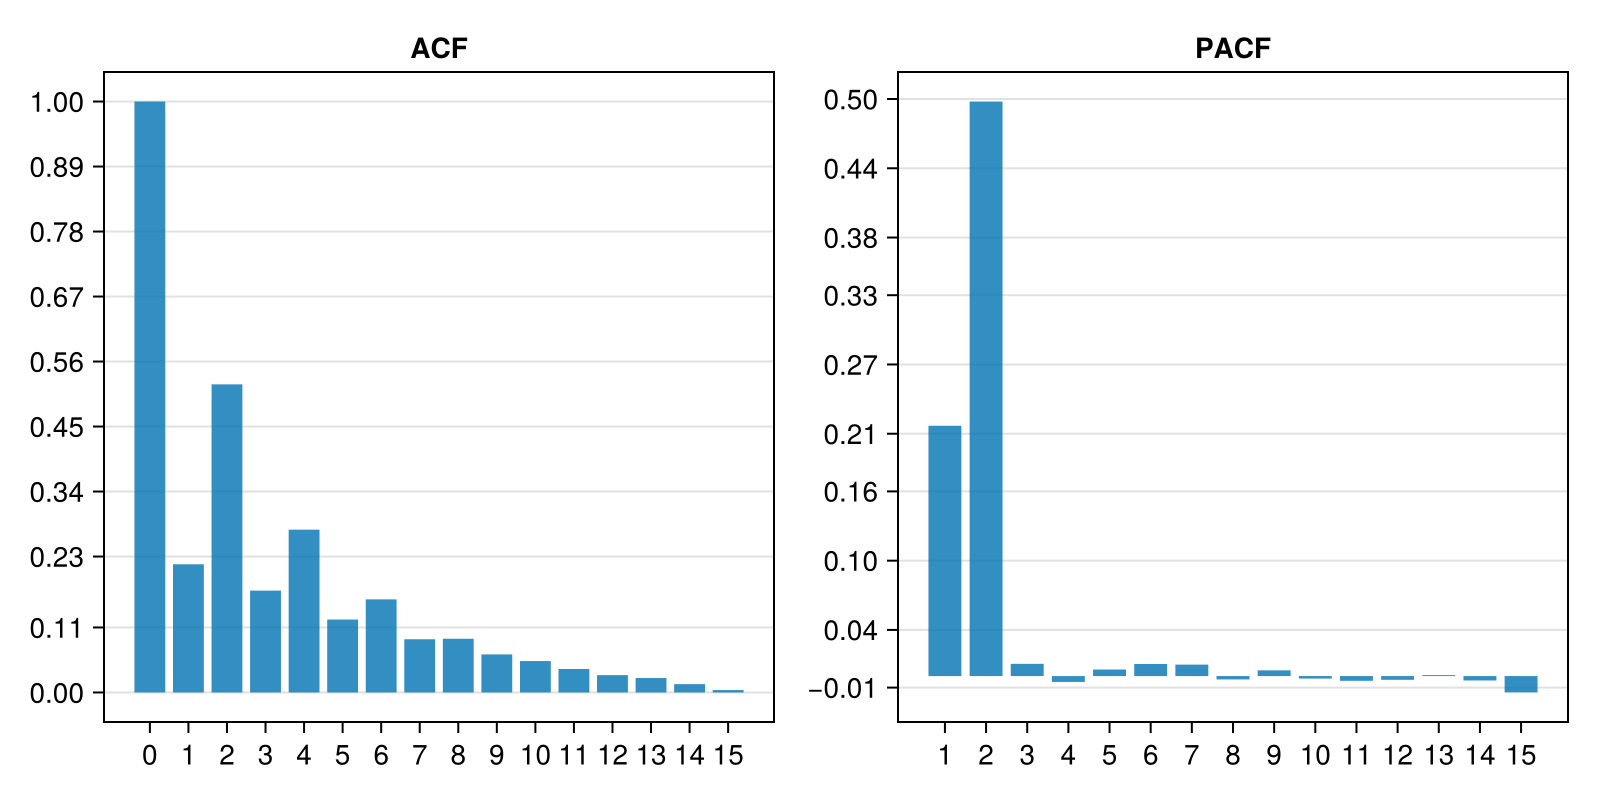

In [6]:
include("utils/ACF_PACF.jl")
ACF_PACF(x)

In [7]:
include("utils/Estimation.jl")
Parameters_est=LL_AR_Estimation(x,2)
Φ1_hat, Φ2_hat, σ_hat=Parameters_est[1][1], Parameters_est[1][2], Parameters_est[2]
table = DataFrame("Parameters"=>"Φ₁", "Error"=>abs(Φ1_hat-Φ[1]), "Relative error"=>abs(Φ1_hat-Φ[1])/abs(Φ[1]))
push!(table,("Φ₂",abs(Φ2_hat-Φ[2]),abs(Φ2_hat-Φ[2])/abs(Φ[2])))
push!(table,("σ",abs(σ_hat-σ),abs(σ_hat-σ)/abs(σ)))

Row,Parameters,Error,Relative error
,String,Float64,Float64
1,Φ₁,0.00898928,0.0898928
2,Φ₂,0.00214458,0.00428915
3,σ,0.00179506,0.000299176


# AR model on each month

Parameters for each month

To find convenient parameters, below I have made an empirical map of where the parameters make the AR(2) series stationnary (in blue) and where they don't (in red)

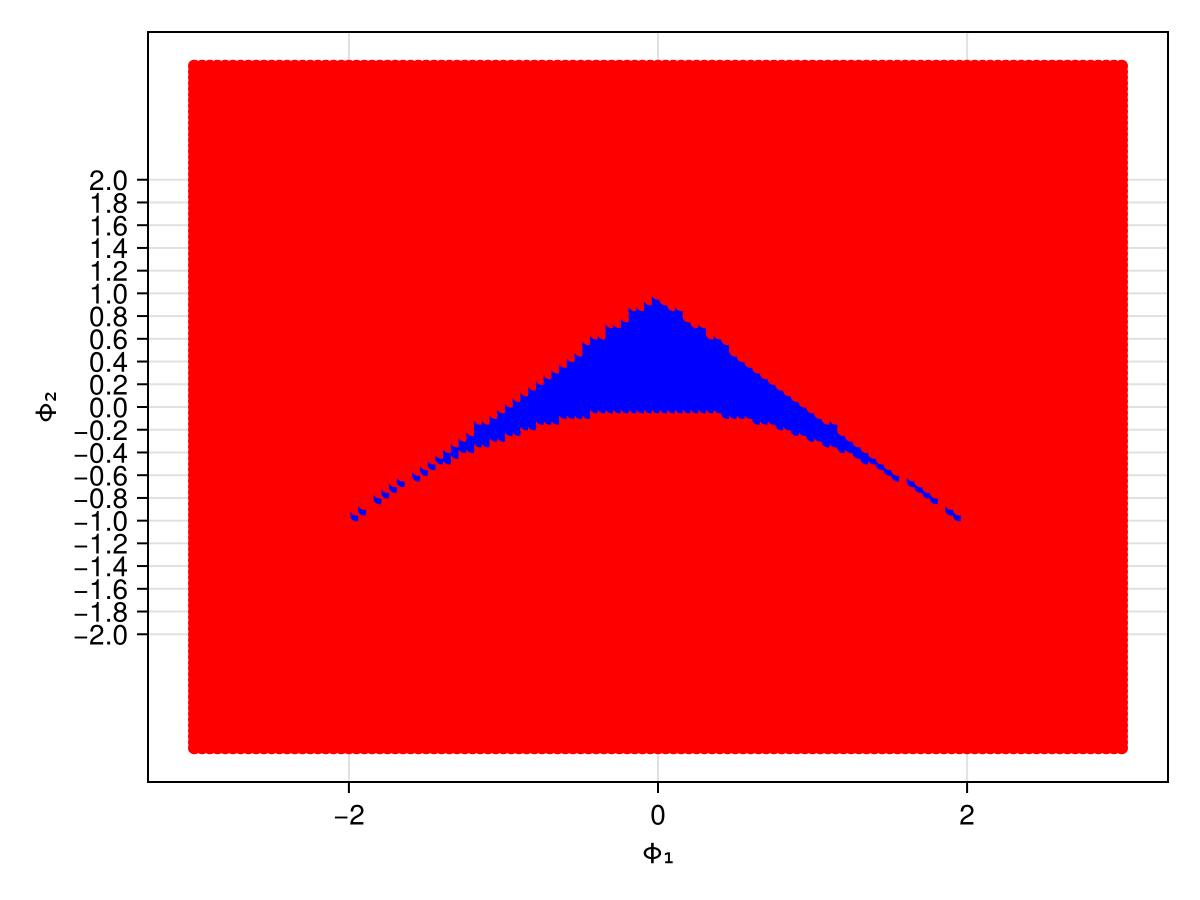

In [8]:
fig=Figure()
ax=Axis(fig[1,1])
ax.yticks=-2:0.2:2
Φ₁ls=-3:.05:3
Φ₂ls=-3:.05:3
condition(r) = (imag(r) == 0) && (abs(r) > 1)
for Φ₁ in Φ₁ls
    for Φ₂ in Φ₂ls
        color = all(condition.(RootAR([Φ₁,Φ₂]))) ? "blue" : "red" 
        scatter!(ax, Φ₁,Φ₂, color=color)
        ax.ylabel="Φ₂"
        ax.xlabel="Φ₁"
    end
end
fig

In [9]:
Φ_month=[[5,2],[-7,1],[1,8],[6,2],[-2,7],[0.5,9],[-3,2],[5,4],[3,1],[-4,3],[3,1],[5,2]] / 10
display(isstationnary.(Φ_month))
Φ1_month, Φ2_month = invert(Φ_month)
σ_month=[1.5,2,4.5,7,8,3,4.5,1,7,2.5,3,6]

12-element BitVector:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

12-element Vector{Float64}:
 1.5
 2.0
 4.5
 7.0
 8.0
 3.0
 4.5
 1.0
 7.0
 2.5
 3.0
 6.0

Generation of the series associated

In [10]:
n_month=200
x=SimulateMonth([7.,4.],Date(2000,11,1),Φ_month,σ_month,n_month)
Date_vec=collect(Date(2000,11,1):(Date(2000,11,1) + Month(n_month) - Day(1)))
Monthly_temp=MonthlySeparateX(x,Date_vec)

12-element Vector{Vector{Any}}:
 [[-3.168450178722559, -2.7872458148241166, -1.794770772858815, -3.6184113574602415, -2.2667664382441846, -3.2442443496406304, -1.3021654627311763, -2.261109559623959, -2.415885064222075, -2.2494248872445683  …  1.5389484322919884, 2.722062663703606, 2.078283442974281, 2.797885964274403, 0.35264006812206117, 0.5947959184002823, 1.479073341934035, 1.0540316924280295, 2.36497259084805, 3.6988416826620587], [-3.780821527655773, -2.1781979783749317, 0.6541534993315772, -1.511220249968794, -0.707640893099835, 2.176102926451664, -2.1893138423290623, -4.2609323330662745, -2.915202870197459, -2.023380724304058  …  -1.7102543213632762, -3.2949319699422195, -3.076230616898724, -1.5519630591428613, -1.1101160962884058, -0.306525716376956, 0.5430345666167279, 0.6380579900665908, -3.3248200674918698, -0.07974913831766828], [10.504027005181628, 9.4171702583164, 9.168951666026953, 5.968269553057058, 4.33917188295783, 2.085249382921484, 2.5681912517181122, -0.2740572675

## Autocorrelations

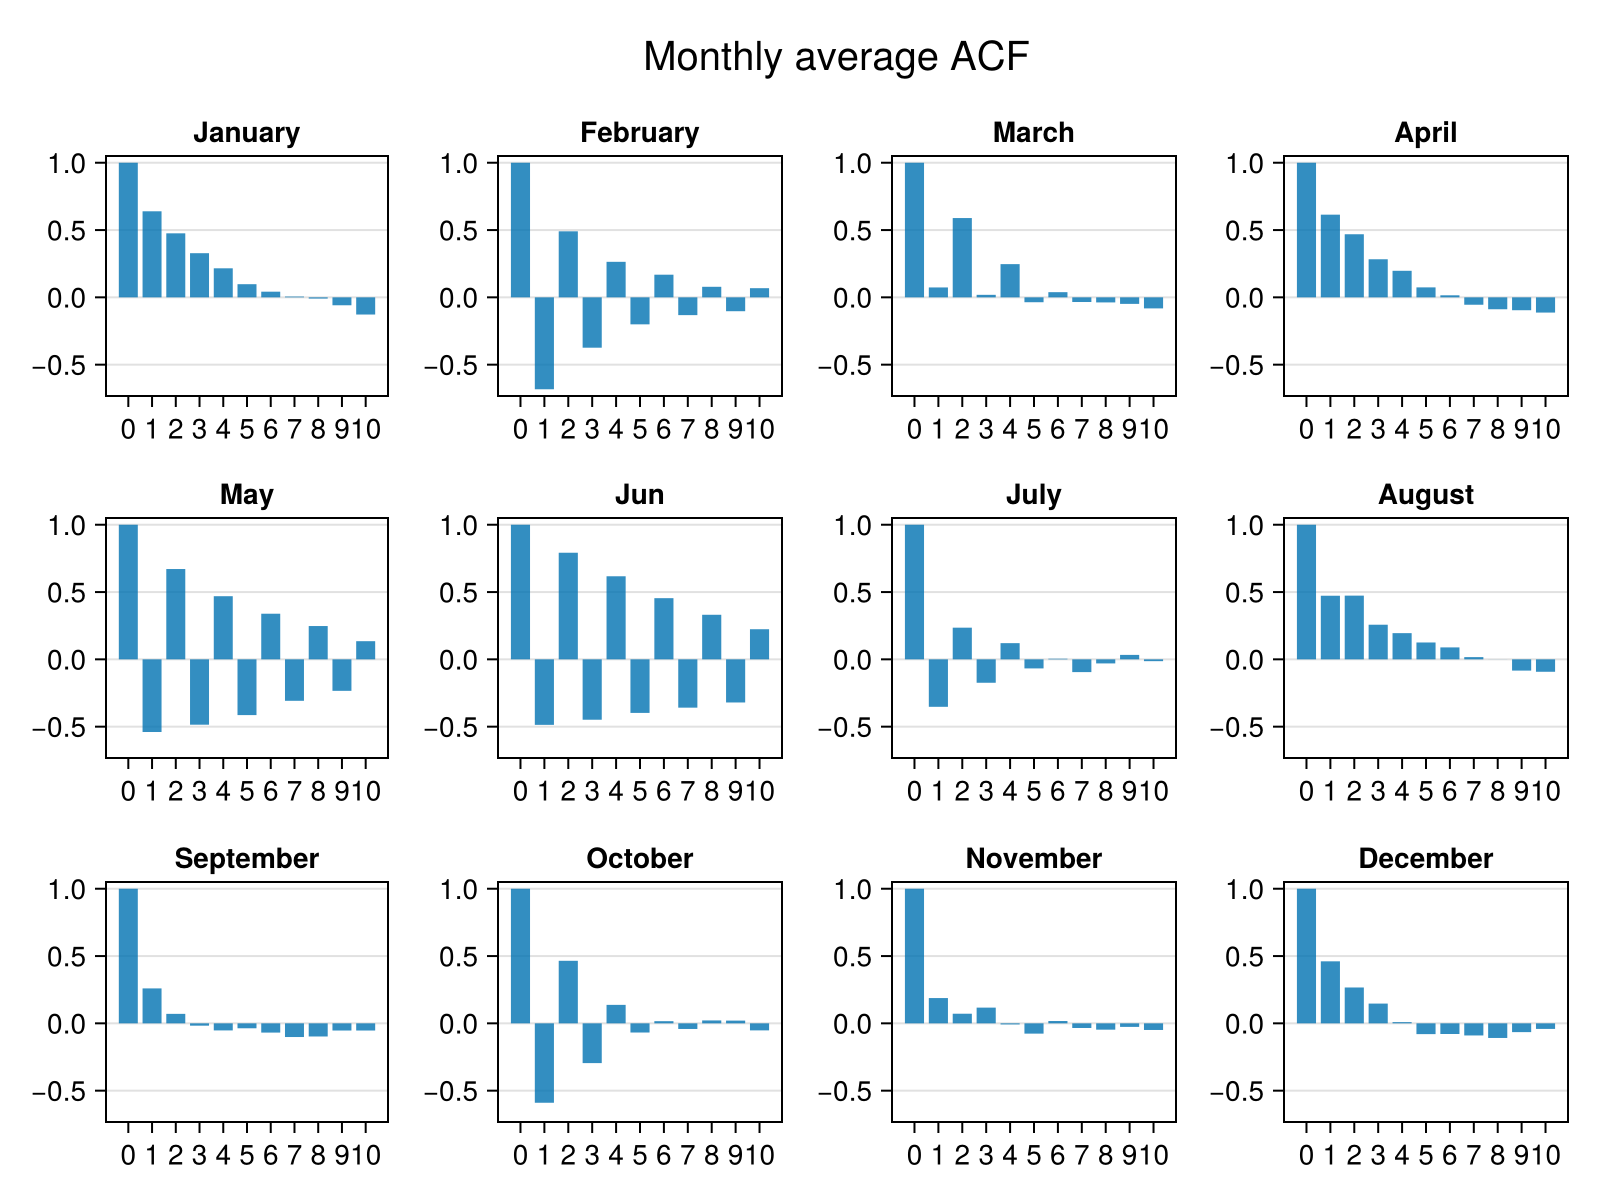

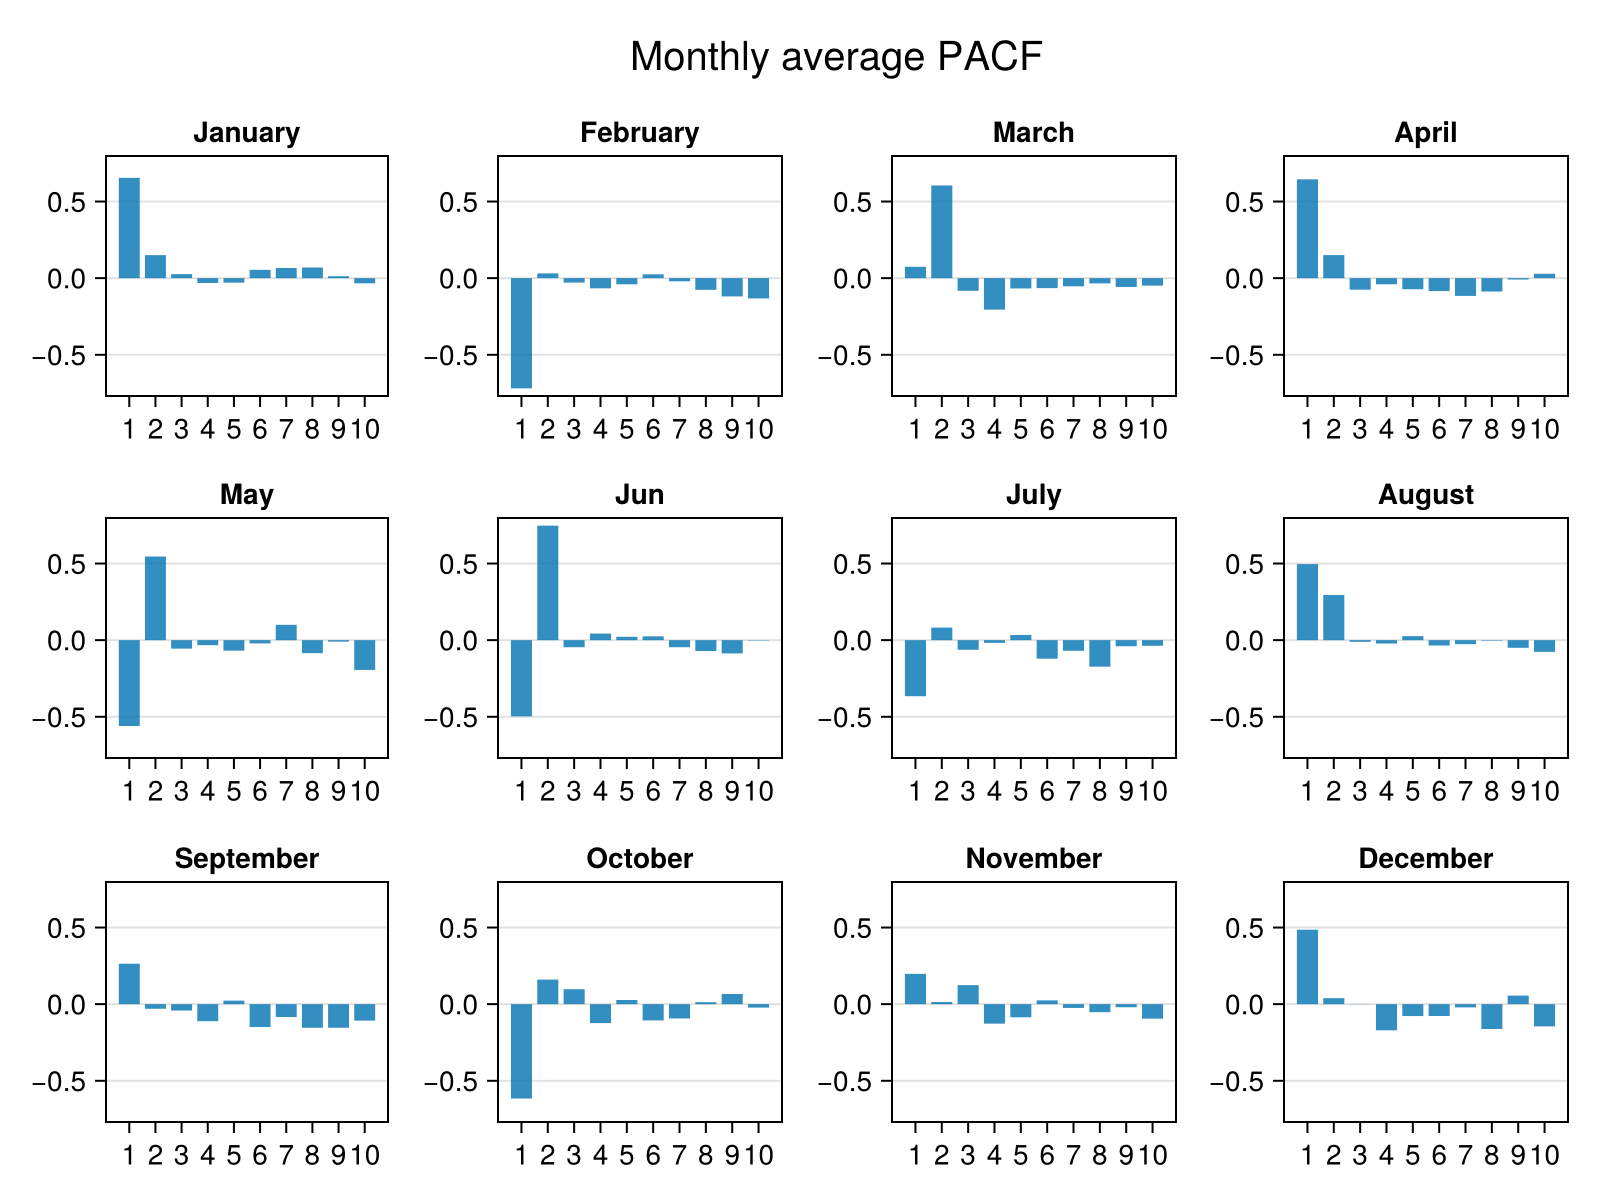

CairoMakie.Screen{IMAGE}


In [11]:
display(MonthlyACF(Monthly_temp))
display(MonthlyPACF(Monthly_temp))

## Estimating models

[[0.35025845656651694, 0.37237366930899435, -0.03938425356381192, 0.808536818774833, 0.6705423967861904, 0.578356747511236, -0.025632026095811316, 0.8156514569910912, 0.45702622911865964, 0.06340010823475704, 0.32545560466728723, 0.46308161712856377, 1.0344671769951113, 0.4378195992705829, 0.7582564692570941, 0.14263900742800698, 0.8516842464114804], [-0.6845940811374019, -0.7097017302118644, -0.46793622689655795, -0.5827891134344644, -0.6966444980727965, -0.8118311721343858, -0.7922454209313124, -0.5503404355201084, -0.7572602982336578, -0.5233619699395033, -1.0270059376490064, -0.6278789788443231, -0.4074561988040505, -0.7977947515377055, -0.5164844891856353, -0.7576859690883129, -0.6781255240435962], [0.1639637038837617, 0.32312070444385943, 0.17611423861578002, 0.00559797628088376, 0.059222472316206726, 0.04696675615895749, 0.12818077942435535, 0.07080154095268637, 0.30025620364457173, 0.033156430798703514, -0.11371071211257058, -0.02842286555348746, 0.28381219807117414, 0.03444152

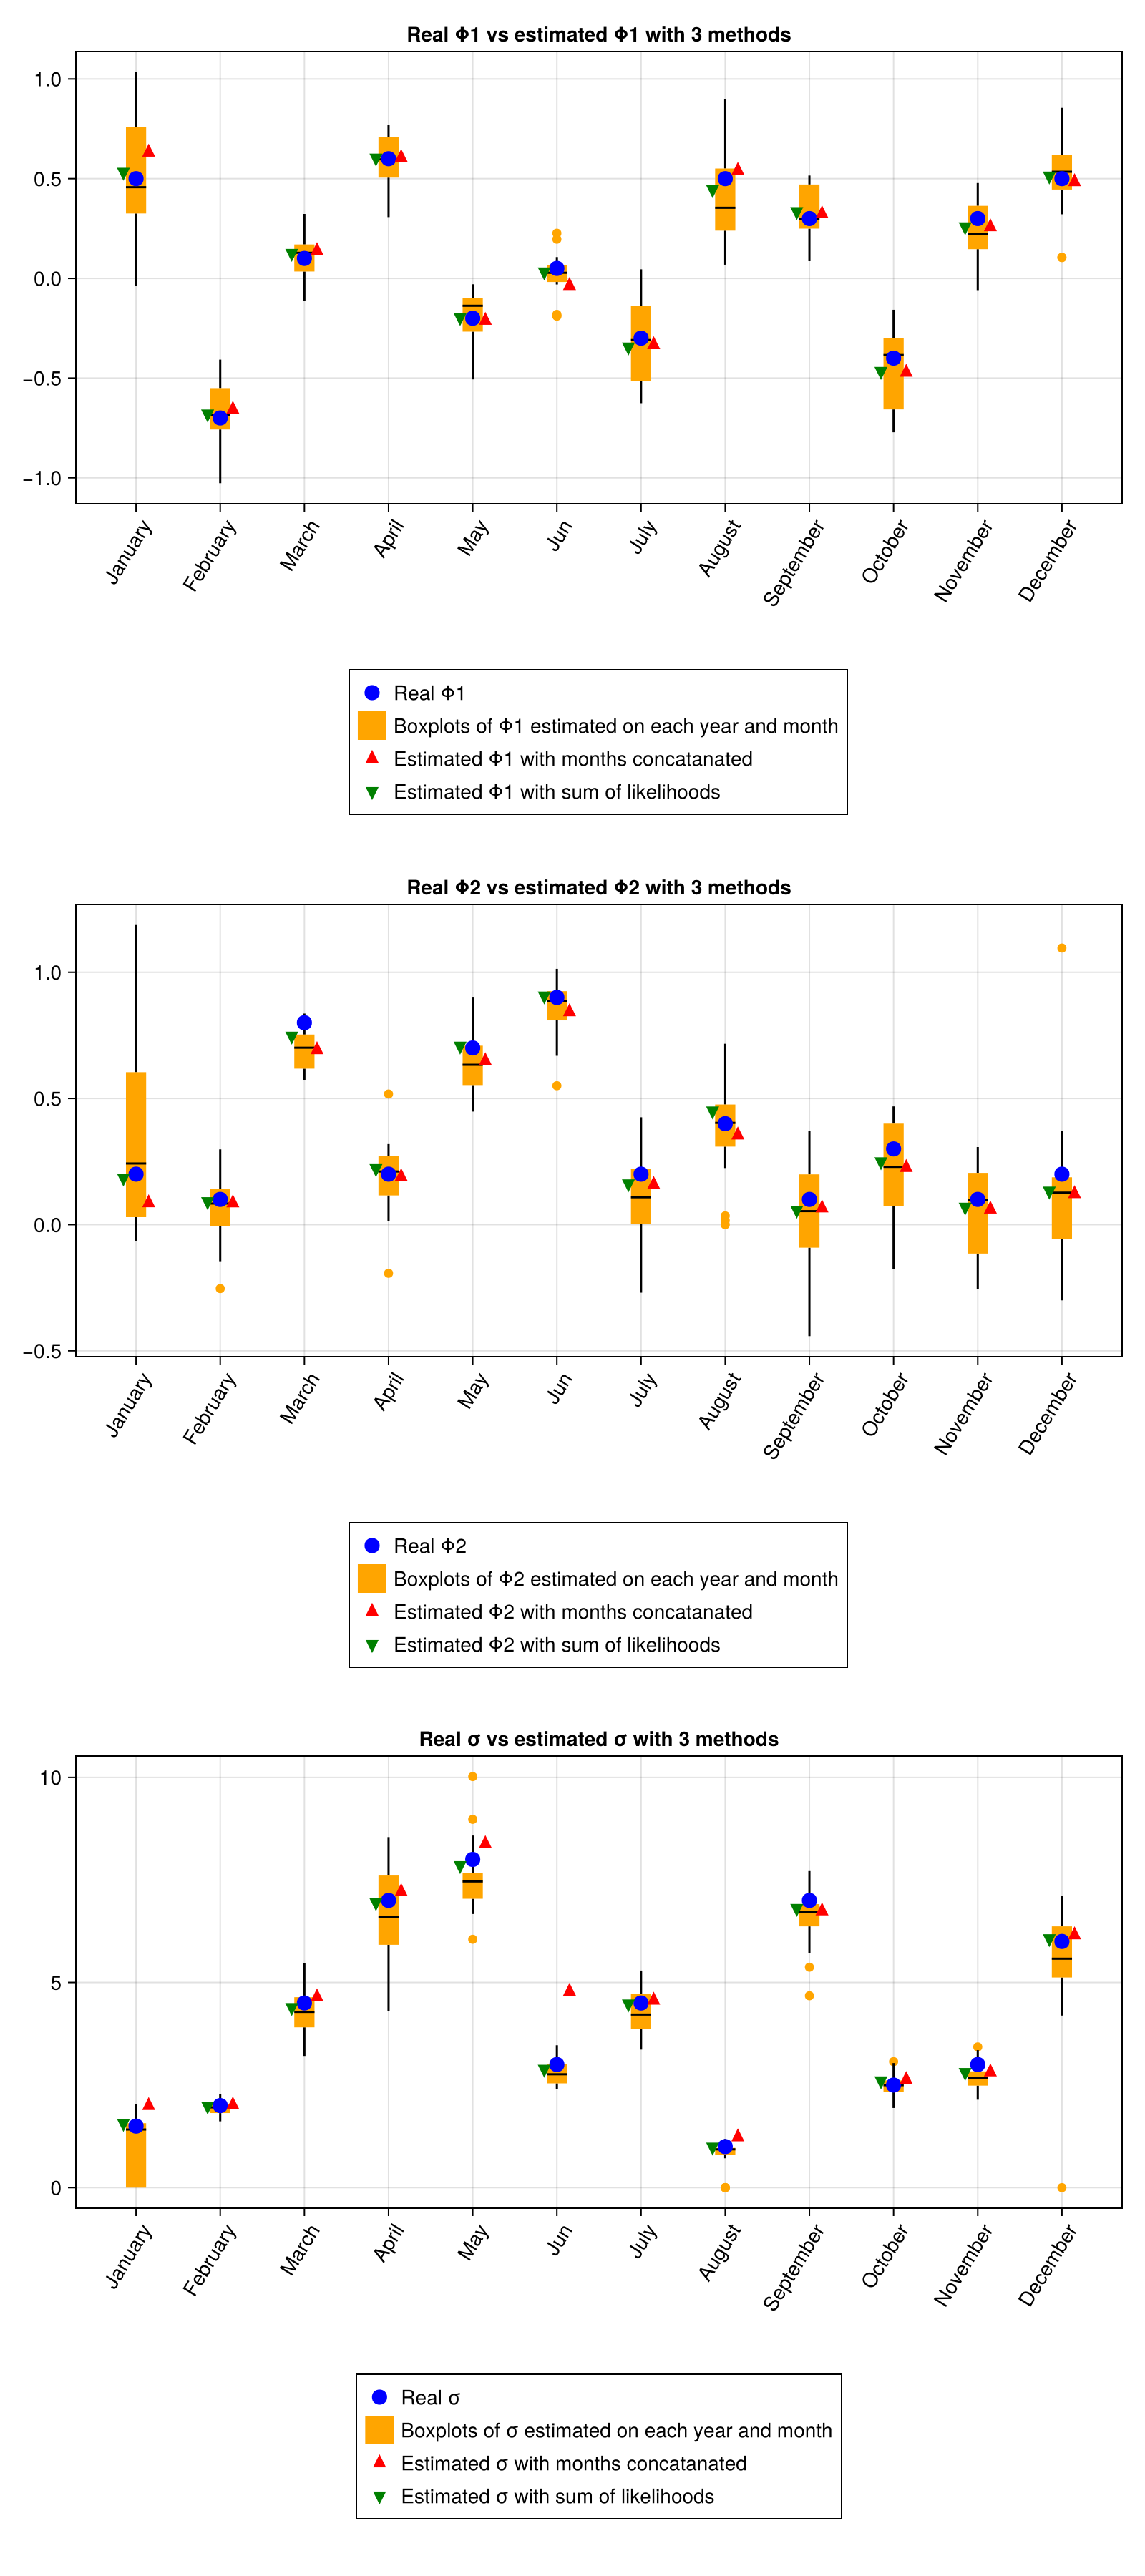

Row,Parameter,Month concatanation,Sum LL,mean of monthly parameters,median of monthly parameters
,String,Float64,Float64,Float64,Float64
1,Φ1,26.0509,11.8647,13.6101,15.4174
2,Φ2,22.6791,15.8079,30.6873,18.4381
3,σ,12.2407,2.45687,9.24457,5.65499


In [12]:
include(raw"utils\Estimation.jl")
Parameters,autofig,ErrorTable=AllEstimation(x,2,Date_vec=Date_vec,TrueParamVec=[Φ1_month,Φ2_month,σ_month])
display(autofig)
display(ErrorTable)

In [13]:
Φ_vec, σ_vec = AutoTakeParameters((Parameters,ErrorTable))
n_years=100
sim=SimulateYears([7.,4.],Date(2001,1,1),Φ_vec, σ_vec,n_years)
sample_=invert(sim)

365-element Vector{Vector{Float64}}:
 [4.0, -2.8435934889460954, 3.0461282476019456, -3.7458621084849364, -5.08238935402002, -4.1664231178219655, -0.3150833974943523, 2.3242003174960617, 7.309808984663777, 6.922534902412728  …  8.195861585939605, -6.95385825788134, 5.660461320141406, -8.312658379356924, -4.907346207999964, -0.14440057643190518, -0.3892149065196089, -2.03934453173926, -6.406113655659527, 5.849933882097263]
 [4.923342315787872, -1.3445140348961049, 4.871456633655843, -1.0999403435587713, -4.365858367224433, -4.035886434282149, 0.006940873832258693, 2.7924279807166967, 4.906583367460058, 5.654085293882581  …  6.373366137792514, -6.438979017572326, 6.466045857393199, -6.869926723581995, -4.077557126767296, -1.7771234395078366, -0.8105864702537041, -2.615579047273718, -6.924286688442867, 5.487330885126627]
 [4.4853538605503624, -1.3231739727301473, 3.9465312299570043, 0.29031398981800227, -1.8057639318634904, -2.110344536640481, -1.6127749035535857, 0.9672323912202796, 5.20

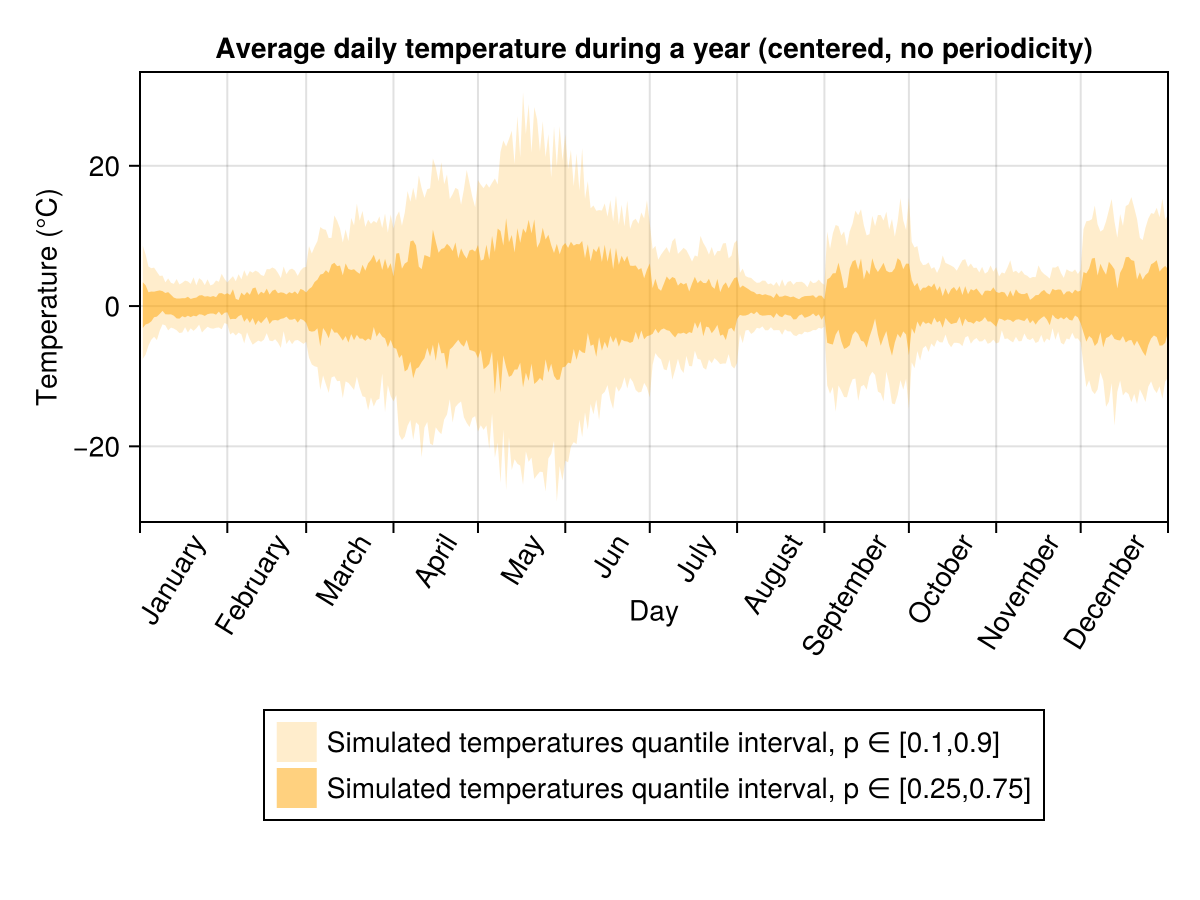

In [14]:
include("utils/Plotting.jl")
PlotYearCurves([],
["Simulated temperatures quantile interval, p ∈ [0.1,0.9]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
"Average daily temperature during a year (centered, no periodicity)",
[(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
[("orange",0.2),("orange",0.5)]
)